# **Mirror Mind**
*Self developing Ai Agent*
basic idea is as we humans , when want to fix things , for an example
very basic example , everyone wants to grow now Consider yourself
You are a 16 years old boy/girl , who is fat and being bullied you won geneic lottery of tall genetics and good facial harmony but you are fat
so now your routine (weights in model context) have to be changed and you dont do it mindlessly or randomly , you predict if I wake up early and go for a run I will burn calories You changed your routine(weights for the model ) and also you cut on junk (biases in model context ) doing calculated changes and doing them overtime according to your goal and deadline needs , this is what `meta-adaptation through self-prediction error.` is ,


---

Now how I am showing it here is
I created a 5 X 5 chess board and set some rules to play , and our `RNN` based model plays the game against it self and tried to win , adjust it own weight and biases and play again and again , focusing on mindful changes and also I try to show what changed and maybe if we can figure out why it is changing , this is gonna help us understand how Ai Agents understand themselfs , like we humans do meditation to understand our inner being.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Phase 0
**`The Chess Board`**

**What is Phase 0?**

We are creating Chess game:
* Visual feedback after every turn (critical for observing and modeling behaviors)

This small arena is ideal for self-play and adaptive introspection. The simpler the world, the faster the brain can learn how to change itself.

In [ ]:
from enum import Enum
import copy

class Color(Enum):
    WHITE = 'white'
    BLACK = 'black'

    def opposite(self):
        return Color.BLACK if self == Color.WHITE else Color.WHITE

class Piece:
    def __init__(self, color: Color):
        self.color = color

    def get_legal_moves(self, board, x, y):
        return []

    def symbol(self):
        return '?'

    def is_opponent(self, other):
        return other and self.color != other.color


class Rook(Piece):
    def get_legal_moves(self, board, x, y):
        return board.slide_moves(x, y, self, [(1,0), (-1,0), (0,1), (0,-1)])

    def symbol(self): return 'R'


class Bishop(Piece):
    def get_legal_moves(self, board, x, y):
        return board.slide_moves(x, y, self, [(1,1), (-1,1), (-1,-1), (1,-1)])

    def symbol(self): return 'B'


class Queen(Piece):
    def get_legal_moves(self, board, x, y):
        return board.slide_moves(x, y, self, [
            (1,0), (-1,0), (0,1), (0,-1),
            (1,1), (-1,1), (-1,-1), (1,-1)
        ])

    def symbol(self): return 'Q'


class Knight(Piece):
    def get_legal_moves(self, board, x, y):
        moves = []
        for dx, dy in [(2,1),(1,2),(-1,2),(-2,1),(-2,-1),(-1,-2),(1,-2),(2,-1)]:
            nx, ny = x+dx, y+dy
            if board.in_bounds(nx, ny):
                target = board.grid[nx][ny]
                if target is None or self.is_opponent(target):
                    moves.append((nx, ny))
        return moves

    def symbol(self): return 'N'


class King(Piece):
    def get_legal_moves(self, board, x, y):
        moves = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx, ny = x+dx, y+dy
                if board.in_bounds(nx, ny):
                    target = board.grid[nx][ny]
                    if target is None or self.is_opponent(target):
                        moves.append((nx, ny))
        return moves

    def symbol(self): return 'K'


class Pawn(Piece):
    def get_legal_moves(self, board, x, y):
        moves = []
        dir = -1 if self.color == Color.WHITE else 1
        start_row = 6 if self.color == Color.WHITE else 1

        # Forward move
        if board.is_empty(x + dir, y):
            moves.append((x + dir, y))
            if x == start_row and board.is_empty(x + 2 * dir, y):
                moves.append((x + 2 * dir, y))

        # Capture moves
        for dy in [-1, 1]:
            nx, ny = x + dir, y + dy
            if board.in_bounds(nx, ny) and board.grid[nx][ny] and self.is_opponent(board.grid[nx][ny]):
                moves.append((nx, ny))

        return moves

    def symbol(self): return 'P'


class Board:
    def __init__(self):
        self.grid = [[None] * 8 for _ in range(8)]
        self.turn = Color.WHITE
        self.setup_pieces()

    def setup_pieces(self):
        order = [Rook, Knight, Bishop, Queen, King, Bishop, Knight, Rook]
        for i, piece_cls in enumerate(order):
            self.grid[0][i] = piece_cls(Color.BLACK)
            self.grid[7][i] = piece_cls(Color.WHITE)

        for i in range(8):
            self.grid[1][i] = Pawn(Color.BLACK)
            self.grid[6][i] = Pawn(Color.WHITE)

    def in_bounds(self, x, y):
        return 0 <= x < 8 and 0 <= y < 8

    def is_empty(self, x, y):
        return self.in_bounds(x, y) and self.grid[x][y] is None

    def slide_moves(self, x, y, piece, directions):
        moves = []
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            while self.in_bounds(nx, ny):
                target = self.grid[nx][ny]
                if target is None:
                    moves.append((nx, ny))
                elif piece.is_opponent(target):
                    moves.append((nx, ny))
                    break
                else:
                    break
                nx += dx
                ny += dy
        return moves

    def display(self):
        print("   a  b  c  d  e  f  g  h")
        for i in range(8):
            print(8 - i, end='  ')
            for j in range(8):
                piece = self.grid[i][j]
                if piece:
                    symbol = piece.symbol()
                    symbol = symbol.upper() if piece.color == Color.WHITE else symbol.lower()
                else:
                    symbol = '.'
                print(symbol, end='  ')
            print(8 - i)
        print("   a  b  c  d  e  f  g  h\n")

    def is_check(self, color):
        king_pos = self.find_king(color)
        if not king_pos:
            return False
        xk, yk = king_pos
        for i in range(8):
            for j in range(8):
                piece = self.grid[i][j]
                if piece and piece.color != color:
                    if (xk, yk) in piece.get_legal_moves(self, i, j):
                        return True
        return False

    def find_king(self, color):
        for i in range(8):
            for j in range(8):
                piece = self.grid[i][j]
                if piece and isinstance(piece, King) and piece.color == color:
                    return (i, j)
        return None

    def get_all_legal_moves(self, color):
        all_moves = []
        for i in range(8):
            for j in range(8):
                piece = self.grid[i][j]
                if piece and piece.color == color:
                    for move in piece.get_legal_moves(self, i, j):
                        if self.is_legal_move(i, j, move[0], move[1]):
                            all_moves.append(((i, j), move))
        return all_moves

    def is_legal_move(self, x1, y1, x2, y2):
        clone = copy.deepcopy(self)
        clone._move_piece(x1, y1, x2, y2)
        return not clone.is_check(self.turn)

    def _move_piece(self, x1, y1, x2, y2):
        self.grid[x2][y2] = self.grid[x1][y1]
        self.grid[x1][y1] = None

    def move_algebraic(self, from_sq, to_sq):
        x1, y1 = 8 - int(from_sq[1]), ord(from_sq[0]) - ord('a')
        x2, y2 = 8 - int(to_sq[1]), ord(to_sq[0]) - ord('a')
        return self.move_piece(x1, y1, x2, y2)

    def move_piece(self, x1, y1, x2, y2):
        piece = self.grid[x1][y1]
        if not piece or piece.color != self.turn:
            return False
        if (x2, y2) not in piece.get_legal_moves(self, x1, y1):
            return False
        if not self.is_legal_move(x1, y1, x2, y2):
            return False
        self._move_piece(x1, y1, x2, y2)
        self.turn = self.turn.opposite()
        return True

    def is_checkmate(self, color):
        return self.is_check(color) and not self.get_all_legal_moves(color)

    def is_stalemate(self, color):
        return not self.is_check(color) and not self.get_all_legal_moves(color)

    def fen(self):
        fen_rows = []
        for row in self.grid:
            empty = 0
            fen_row = ''
            for piece in row:
                if piece is None:
                    empty += 1
                else:
                    if empty > 0:
                        fen_row += str(empty)
                        empty = 0
                    symbol = piece.symbol()
                    fen_row += symbol.upper() if piece.color == Color.WHITE else symbol.lower()
            if empty > 0:
                fen_row += str(empty)
            fen_rows.append(fen_row)
        return '/'.join(fen_rows) + ' ' + ('w' if self.turn == Color.WHITE else 'b')

# Phase 1
**`Setting rule of movement`**

**Desclaimer** -- This was created in very intial stage of research
(OMIT THIS)
Later I switched added everything to The main ChessBoard class inself

1. Piece movement logic:

* * Pawn: forward + capture diagonally

* * Knight: L-shape

* * King: one square in any direction

2. Legal move generation

3. Random move agent (baseline opponent)

4. Visualized gameplay (piece animations per move)

Logging of state → this will later be used by the self-model to reflect on its own decisions

Now we are gonna code functions for phase 1 which will aplly dynamic change in position of piece , and log it in embeddings
now changes in these logging

        def get_legal_moves(self, color='white'):
        # Basic movement rules for each piece
          moves = []
          piece_set = {'white': ['K', 'N', 'P'], 'black': ['k', 'p']}
          directions = {
              'K': [(-1, 0), (1, 0), (0, 1), (0, -1), (-1, -1), (1, 1), (-1, 1), (1, -1)],
              'N': [(-2, -1), (-2, 1), (-1, -2), (-1, 2),
                    (1, -2), (1, 2), (2, -1), (2, 1)],
              'P': [(-1, 0)],
              'p': [(1, 0)],
          }

          for row in range(4):
              for col in range(6):
                  piece = self.board[row][col]
                  if piece in piece_set[color]:
                      for dr, dc in directions.get(piece.upper(), []):
                          new_r, new_c = row + dr, col + dc
                          if 0 <= new_r < 4 and 0 <= new_c < 6:
                              target = self.board[new_r][new_c]
                              if target == ' ' or (color == 'white' and target.islower()) or (color == 'black' and target.isupper()):
                                  moves.append(((row, col), (new_r, new_c)))
          return moves

        def move_piece(self, from_pos, to_pos):
            fr, fc = from_pos
            tr, tc = to_pos
            piece = self.board[fr][fc]
            self.board[tr][tc] = piece
            self.board[fr][fc] = ' '

            # Switch turn
            self.turn = 'black' if self.turn == 'white' else 'white'

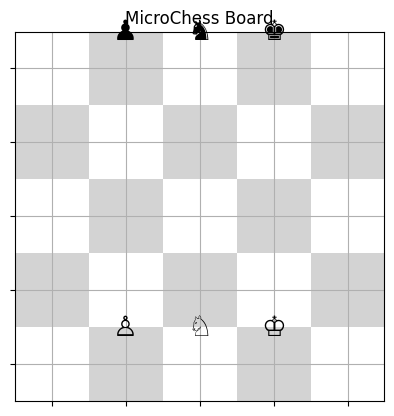

Available moves: [((4, 1), (3, 1)), ((4, 2), (2, 1)), ((4, 2), (2, 3)), ((4, 2), (3, 0)), ((4, 2), (3, 4)), ((4, 3), (3, 3)), ((4, 3), (4, 4)), ((4, 3), (3, 2)), ((4, 3), (3, 4))]
Chosen move: ((4, 3), (4, 4))


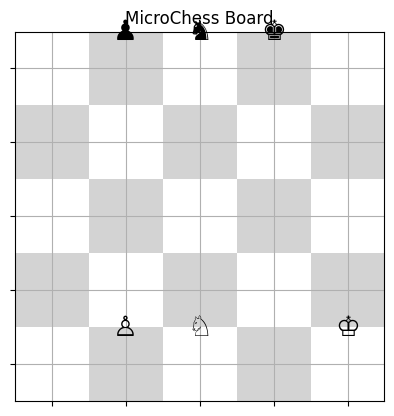

In [ ]:
game = MicroChess()
game.render()

moves = game.get_legal_moves('white')
print("Available moves:", moves)

if moves:
    move = random.choice(moves)
    print("Chosen move:", move)
    game.move_piece(*move)
    game.render()

# Phase 2
**`Creating Two AI agents`**

**GOAL:**

Goal here is to design 2 strong Ai models which have 0 idea of chess and are given restricted moves (or better said playable moves)



---

Below is a PyTorch implementation of an advanced RNN-based chess agent. It’s designed as an actor-critic network so it can both evaluate board positions (value head) and select moves (policy head). The RNN backbone lets it capture sequential patterns (e.g. move history), and we wrap it with LayerNorm, residual connections, and dropout for stability and generalization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNNChessAgent(nn.Module):
    def __init__(self,
                 input_dim: int = 8*8*12,   # one-hot board encoding: 12 piece types × 64 squares
                 hidden_dim: int = 512,
                 rnn_layers: int = 2,
                 dropout: float = 0.3,
                 n_moves: int = 8*8*8*8   # worst-case move space (from-to)
                 ):
        super().__init__()

        # 1) Input projection to hidden_dim
        self.input_fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
        )

        # 2) Multi-layer LSTM backbone
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )

        # 3) Residual projection after LSTM
        self.res_proj = nn.Linear(hidden_dim, hidden_dim)

        # 4) Policy head: maps to move logits
        self.policy_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, n_moves)
        )

        # 5) Value head: scalar value for position
        self.value_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 1),
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, board_seq: torch.Tensor,   # shape: (batch, seq_len, input_dim)
                hidden: tuple = None
                ) -> tuple:
        """
        Args:
            board_seq: one-hot encoded board states over time,
                       shape (B, T, 768)
            hidden: optional (h0, c0) for LSTM

        Returns:
            policy_logits: (B, T, n_moves)
            values:        (B, T, 1)
            hidden:        new (h, c)
        """

        # project inputs
        x = self.input_fc(board_seq)             # (B, T, hidden_dim)

        # RNN
        out, hidden = self.lstm(x, hidden)       # (B, T, hidden_dim)

        # residual connection
        out = out + self.res_proj(x)             # (B, T, hidden_dim)

        # policy & value from each time step
        policy_logits = self.policy_head(out)    # (B, T, n_moves)
        values       = self.value_head(out)      # (B, T, 1)

        return policy_logits, values, hidden

    def act(self,
            current_board: torch.Tensor,  # (1, 1, input_dim)
            hidden: tuple = None,
            legal_mask: torch.Tensor = None  # (1, n_moves)
            ) -> tuple:
        """
        Given the current board, produce a move distribution and value.

        Returns:
            probs: (1, n_moves)
            value: (1, 1)
            hidden: new hidden state
        """
        logits, value, hidden = self.forward(current_board, hidden)
        logits = logits[:, -1, :]  # take last time step
        if legal_mask is not None:
            logits = logits.masked_fill(~legal_mask, float('-inf'))
        probs = F.softmax(logits, dim=-1)
        return probs, value[:, -1], hidden

    def save(self, path: str):
        torch.save(self.state_dict(), path)

    def load(self, path: str, device: torch.device = None):
        state = torch.load(path, map_location=device)
        self.load_state_dict(state)


In [ ]:
agent = RNNChessAgent()
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load previous weights if any
#agent.load('rnn_agent.pt', device)
for epoch in range(N_epochs):
    boards, legal_masks, rewards = generate_self_play(agent, ...)
    # boards: (batch, seq_len, 768)
    # legal_masks: (batch, n_moves)
    # rewards: game outcomes or advantage estimates

    probs, values, _ = agent(boards)  # policy: (B, T, M), values: (B, T, 1)
    # compute policy loss + value loss, backpropagate...
    loss = policy_loss(probs, legal_masks, rewards) + value_loss(values, rewards)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# save for next run
agent.save('rnn_agent.pt')

NameError: name 'generate_self_play' is not defined

Below is an advanced Transformer‐based chess agent in PyTorch. It mirrors the RNN agent’s actor-critic design but replaces the LSTM backbone with a multi-layer Transformer encoder to better capture long-range dependencies (e.g., planning ahead across many moves). It includes positional embeddings, residual blocks, LayerNorm, and dropout for stability.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
boards=Board()
class TransformerChessAgent(nn.Module):
    def __init__(self,
                 input_dim: int = 8*8*12,   # one-hot board encoding
                 d_model: int = 512,
                 n_heads: int = 8,
                 n_layers: int = 6,
                 dim_ff: int = 2048,
                 dropout: float = 0.3,
                 max_seq_len: int = 32,     # track up to last 32 positions
                 n_moves: int = 8*8*8*8
                 ):
        super().__init__()
        # 1) Input projection + positional embeddings
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_embed = nn.Parameter(torch.zeros(1, max_seq_len, d_model))
        self.dropout = nn.Dropout(dropout)

        # 2) Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # 3) Residual projection (optional)
        self.res_proj = nn.Linear(d_model, d_model)

        # 4) Policy head
        self.policy_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, n_moves),
        )
        # 5) Value head
        self.value_head = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model//2, 1),
            nn.Tanh()
        )
    print("boards.shape:", boards.shape)


    def forward(self, board_seq: torch.Tensor):
        """
        Args:
            board_seq: (B, T, input_dim)  where T ≤ max_seq_len
        Returns:
            policy_logits: (B, T, n_moves)
            values:        (B, T, 1)
        """
        B, T, _ = board_seq.shape
        # project inputs
        x = self.input_fc(board_seq)               # (B, T, d_model)
        # add positional
        x = x + self.pos_embed[:, :T, :]
        x = self.dropout(x)

        # transformer encoding
        out = self.transformer(x)                  # (B, T, d_model)
        # residual
        out = out + self.res_proj(x)               # (B, T, d_model)

        # heads
        policy_logits = self.policy_head(out)      # (B, T, n_moves)
        values       = self.value_head(out)        # (B, T, 1)
        return policy_logits, values

    def act(self,
            current_board_seq: torch.Tensor,  # shape: (1, T, input_dim)
            legal_mask: torch.Tensor = None   # shape: (1, n_moves)
            ):
        """
        Selects an action from the latest board state.

        Args:
            current_board_seq: Tensor of shape (1, T, input_dim)
            legal_mask: Tensor of shape (1, n_moves), 1 for legal, 0 for illegal

        Returns:
            probs: Tensor of shape (1, n_moves) — probability distribution
            value: Tensor of shape (1, 1) — estimated value for the current state
        """
        self.eval()  # set to inference mode
        with torch.no_grad():
            policy_logits, values = self.forward(current_board_seq)  # (1, T, n_moves), (1, T, 1)
            policy_logits = policy_logits[:, -1, :]  # take only last timestep
            value = values[:, -1, :]                 # take only last value

            if legal_mask is not None:
                # Mask out illegal moves by setting their logits to -inf
                policy_logits[legal_mask == 0] = float('-inf')

            probs = torch.softmax(policy_logits, dim=-1)  # (1, n_moves)
            return probs, value


    def save(self, path: str):
        torch.save(self.state_dict(), path)

    def load(self, path: str, device: torch.device = None):
        state = torch.load(path, map_location=device)
        self.load_state_dict(state)

AttributeError: 'Board' object has no attribute 'shape'

In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 91.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.2-py3-none-any.whl size=147775 sha256=ea3fe4720e8b3520b306873949c5f5683aeb6a0017e0b03d777b4e82e2ec1d21
  Stored in directory: /root/.cache/pip/wheels/fb/5d/5c/59a62d8a695285e59ec9c1f66add6f8a9ac4152499a2be0113
Successfully built chess


In [ ]:
import os
EPOCHS=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize agent and optimizer
agent_1 = TransformerChessAgent().to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=3e-4)

# Checkpoint path
checkpoint_path = '/content/drive/MyDrive/transformer_agent.pt'

# Load previous model if checkpoint exists
if os.path.exists(checkpoint_path):
    agent.load(checkpoint_path, device=device)
    print(f"✅ Loaded model from {checkpoint_path}")
else:
    print("🚀 No existing checkpoint found. Starting fresh.")

# Training loop
for epoch in range(EPOCHS):
    print(f"\n🎯 Epoch {epoch+1}/{EPOCHS}")

    # Generate self-play data (make sure this uses `agent`, not `transformer_agent`)
    boards, masks, rewards = generate_self_play(agent=agent_1)  # fill in the missing params

    # Forward pass
    policy_logits, values = agent(boards.to(device))  # (B, T, M), (B, T, 1)

    # Compute loss
    loss = policy_loss(policy_logits, masks.to(device), rewards.to(device)) \
         + value_loss(values, rewards.to(device))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"🔁 Loss: {loss.item():.4f}")

# Save the model for future use
agent.save(checkpoint_path)
print(f"\n💾 Model saved to {checkpoint_path}")


Using device: cuda
🚀 No existing checkpoint found. Starting fresh.

🎯 Epoch 1/1


RuntimeError: CUDA error: invalid configuration argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# The Feeding
`board to tensor`



In [ ]:
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 145.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import random
from typing import Tuple
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
import os

BOARD_SIZE = 8
PIECE_TYPES = 12
INPUT_DIM = BOARD_SIZE * BOARD_SIZE * PIECE_TYPES
MOVE_SPACE = BOARD_SIZE * BOARD_SIZE * BOARD_SIZE * BOARD_SIZE

def board_to_tensor(board: Board) -> torch.Tensor:
    piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }
    tensor = torch.zeros(INPUT_DIM)
    for x in range(BOARD_SIZE):
        for y in range(BOARD_SIZE):
            piece = board.grid[x][y]
            if piece:
                symbol = piece.symbol().upper() if piece.color.name == 'WHITE' else piece.symbol().lower()
                idx = piece_map[symbol]
                tensor[idx * BOARD_SIZE * BOARD_SIZE + x * BOARD_SIZE + y] = 1
    return tensor

def generate_self_play(agent, num_games=10, max_moves=10000) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    boards, legal_masks, rewards = [], [], []

    for game_id in range(num_games):
        board = Board()
        game_boards = []
        game_masks = []
        game_result = 0  # +1 win, -1 loss, 0 draw

        for _ in range(max_moves):
            state = board_to_tensor(board).unsqueeze(0).unsqueeze(0).to(next(agent.parameters()).device)  # (1, 1, INPUT_DIM)

            legal = board.get_all_legal_moves(board.turn)
            if not legal:
                game_result = -1 if board.is_check(board.turn) else 0
                break

            legal_mask = torch.zeros(MOVE_SPACE, dtype=torch.float32)
            move_index_map = {}

            for (x1, y1), (x2, y2) in legal:
                idx = (x1 * 8 + y1) * 64 + (x2 * 8 + y2)
                legal_mask[idx] = 1.0
                move_index_map[idx] = ((x1, y1), (x2, y2))

            probs, value = agent.act(state, legal_mask.unsqueeze(0).to(state.device))
            move_idx = torch.multinomial(probs[0], 1).item()
            if move_idx not in move_index_map:
                continue

            (x1, y1), (x2, y2) = move_index_map[move_idx]
            board.move_piece(x1, y1, x2, y2)

            game_boards.append(state.squeeze(0))         # shape (1, INPUT_DIM)
            game_masks.append(legal_mask.clone())        # shape (MOVE_SPACE,)
            # You can choose to use value.item() or game_result later
            # game_values.append(value.item())  # if needed

        # Assign game result reward
        result_tensor = torch.tensor([game_result], dtype=torch.float32)
        for i in range(len(game_boards)):
            boards.append(game_boards[i])
            legal_masks.append(game_masks[i])
            rewards.append(result_tensor)

    return (
        torch.stack(boards),        # shape (B, 1, INPUT_DIM)
        torch.stack(legal_masks),  # shape (B, MOVE_SPACE)
        torch.stack(rewards)       # shape (B, 1)
    )

def policy_loss(probs: torch.Tensor, legal_masks: torch.Tensor, rewards: torch.Tensor) -> torch.Tensor:
    log_probs = torch.log(probs + 1e-8)
    selected_log_probs = torch.sum(log_probs * legal_masks, dim=1)
    return -torch.mean(selected_log_probs * rewards.squeeze())


def value_loss(values: torch.Tensor, rewards: torch.Tensor) -> torch.Tensor:
    return F.mse_loss(values.squeeze(), rewards.squeeze())

def train(agent, optimizer, epochs=10, checkpoint_path='rnn_agent.pt', log_dir='runs/mirrormind'):
    writer = SummaryWriter(log_dir=log_dir)
    start_epoch = 0

    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        agent.load(checkpoint_path)
        start_epoch = int(checkpoint_path.split('_')[-1].replace('.pt', '')) + 1 if '_' in checkpoint_path else 0

    for epoch in tqdm(range(start_epoch, start_epoch + epochs), desc="Training Epochs"):
        boards, masks, rewards = generate_self_play(agent)
        boards = boards.view(-1, 1, INPUT_DIM)

        probs, values, _ = agent(boards)
        probs = F.softmax(probs.squeeze(1), dim=-1)
        loss_p = policy_loss(probs, masks, rewards)
        loss_v = value_loss(values.squeeze(1), rewards)
        loss = loss_p + loss_v

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/Total', loss.item(), epoch)
        writer.add_scalar('Loss/Policy', loss_p.item(), epoch)
        writer.add_scalar('Loss/Value', loss_v.item(), epoch)

        print(f"Epoch {epoch+1}, Total Loss: {loss.item():.4f}, Policy: {loss_p.item():.4f}, Value: {loss_v.item():.4f}")

        save_path = checkpoint_path.replace('.pt', f'_{epoch}.pt') if '_' not in checkpoint_path else checkpoint_path
        agent.save(save_path)

    writer.close()

In [ ]:
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 158.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.0 MB/s eta 0:00:00


In [ ]:
!tail logs/introspection_log.jsonl

tail: cannot open 'logs/introspection_log.jsonl' for reading: No such file or directory


**RNN TRAINER**

In [ ]:
agent = RNNChessAgent()
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)
train(agent, optimizer, epochs=50)

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

TypeError: Board.move_piece() missing 2 required positional arguments: 'x2' and 'y2'

**TRANSFORMER TRAINER**

In [ ]:
agent = TransformerChessAgent()
optimizer = torch.optim.Adam(agent.parameters(), lr=3e-4)
train(agent, optimizer, epochs=50)

NameError: name 'TransformerChessAgent' is not defined

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/mirrormind